In [196]:
import networkx as nx
import osmnx as ox
import numpy as np
import warnings
import logging

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
 
logging.basicConfig(filename = 'path_planning.log',
                    filemode="w",
                    level = logging.DEBUG,
                    format = '%(asctime)s:%(levelname)s:%(name)s:%(message)s')

logging.error("Start of the program")

warnings.filterwarnings('ignore')



In [ ]:
tube_color_dict = {
	'Bakerloo': "#ae6118",
	'Central': "#ae6118",
	'District': "#00a575",
	'Circle': "#f8d42d",
    'DLR': "#00bbb4",
    'Hammersmith and City': "#e899a8",
	'Jubilee': "#8f989e",
	'Metropolitan': "#893267",
	'Northern': "#1C1C1C",
    'Overground': "#F86C00",
	'Piccadilly': "#0450a1",
	'Victoria': "#009fe0",
	'Waterloo and City': "#70c3ce",
    'Elizabeth': "#603E99"
}

MAP_PATH = "./data/london.graphml"
MAP_TUBE_PATH = "./data/london_tube.graphml"

LONDON_NORTH, LONDON_SOUTH, LONDON_EAST, LONDON_WEST = 51.672343, 51.384940, 0.148271, -0.351468

ACCEPTABLE_WALKING_DISTANCE = 1000 # 1 km
ACCEPTABLE_WALKING_TIME = 5 * 60 # 8 minutes
NEARBY_STATION_NUM = 3

TRANSFERS_PENALTY = 5
COST_PENALTY = 0
WK_WEIGHT = 1


WALKING_SPEED = 1.34112 # m/s
WALKING_SPEED_MALE = 1.4 # m/s
WALKING_SPEED_FEMALE = 1.31 # m/s
WALKING_SPEED_YOUNG = 1.45 # m/s
WALKING_SPEED_OLD = 1.19 # m/s

tube_speeds = [27.04, 37.29, 24.31, 29.44, 27.65, 40.32, 44.14, 34.09, 32.65, 42.49, 33.30]
TRANSPORT_SPEED =  (np.mean(tube_speeds) - 10) / 3.6 # km/h to m/s

In [197]:
origin_address = 'Finchley Road Station, London, UK'
dest_address = 'Covent Garden, London, UK'
address_compact = origin_address.split(",")[0].replace(" ", "_") + '-' + dest_address.split(",")[0].replace(" ", "_")
origin_lat, origin_lon = ox.geocode(origin_address)
dest_lat, dest_lon = ox.geocode(dest_address)

In [198]:
def get_bbox_bound_from_coord(lat1, lon1, lat2, lon2):
    north, south, east, west = -100, 100, -100, 100
    if lat1 > north: north = lat1
    if lat2 > north: north = lat2
    if lat1 < south: south = lat1
    if lat2 < south: south = lat2
    if lon1 > east: east = lon1
    if lon2 > east: east = lon2
    if lon1 < west: west = lon1
    if lon2 < west: west = lon2

    diff = 0.03
    
    return north+diff, south-diff, east+diff, west-diff

In [199]:
# G = ox.graph_from_bbox(51.54, 51.48, -0.01, -0.16, network_type="walk")
north, south, east, west = get_bbox_bound_from_coord(origin_lat, origin_lon, dest_lat, dest_lon)
G = ox.graph_from_bbox(north, south, east, west, network_type="walk")
# ox.save_graphml(G, MAP_PATH)

In [200]:
origin, dist1 = ox.nearest_nodes(G, origin_lon, origin_lat, return_dist=True)
dest, dist2 = ox.nearest_nodes(G, dest_lon, dest_lat, return_dist=True)

In [201]:
# add weights to walking edges based on age/gender
for u, v, k, data in G.edges(data=True, keys=True):
    data['color'] = '#AAFF00'
    distance = data["length"]
    data["time"] = data["time_fake"] = round(distance / WALKING_SPEED * WK_WEIGHT)
    data["time_male"] = round(distance / WALKING_SPEED_MALE)
    data["time_female"] = round(distance / WALKING_SPEED_FEMALE)
    data["time_young"] = round(distance / WALKING_SPEED_YOUNG)
    data["time_old"] = round(distance / WALKING_SPEED_OLD)
    # logging.debug(f"distance: {round(data['length'], 3)} m \twk time: {round(data['time_old'], 3)} seconds (old)")
    # logging.debug(f"distance: {round(data['length'], 3)} m \twk time: {round(data['time_female'], 3)} seconds (female)")
    # logging.debug(f"distance: {round(data['length'], 3)} m \twk time: {round(data['time'], 3)} seconds (google)")
    # logging.debug(f"distance: {round(data['length'], 3)} m \twk time: {round(data['time_male'], 3)} seconds (male)")
    # logging.debug(f"distance: {round(data['length'], 3)} m \twk time: {round(data['time_young'], 3)} seconds (young)")

G_wk = G.copy()

In [202]:
import json

with open('input/LondonTubeLines_minimal.json', 'r') as f:
    data = json.load(f)

tube_lines, route_colors = [], []
stations_osmid = set()
# Iterating through the json list
for tube_route in data['features']:
    start_end = tube_route['geometry']['coordinates']
    orig_lon, orig_lat = start_end[0][0], start_end[0][1]
    end_lon, end_lat = start_end[1][0], start_end[1][1]

    orig_node, dist1 = ox.nearest_nodes(G, orig_lon, orig_lat, return_dist=True)
    end_node, dist2 = ox.nearest_nodes(G, end_lon, end_lat, return_dist=True)

    # ignore stations and routes that are not within 50m of the graph
    if dist1 > 50 or dist2 > 50:
        continue

    stations_osmid.add(orig_node)
    stations_osmid.add(end_node)

    line_color = tube_route['properties']['stroke']
    feature_str = tube_route['properties']['name'].split(' - ')
    line_name = feature_str[0]
    start_station_name = feature_str[1].split(' to ')[0].split(' (')[0]
    end_station_name = feature_str[1].split(' to ')[1].split(' (')[0]

    # add line info to start station
    G.nodes[orig_node]['station_name'] = start_station_name

    try: 
        G.nodes[orig_node]['lines_name'].add(line_name)
    except (KeyError, AttributeError) as e:
        G.nodes[orig_node]['lines_name'] = {line_name}
    
    # add line info to end station
    G.nodes[end_node]['station_name'] = end_station_name

    try: 
        G.nodes[end_node]['lines_name'].add(line_name)
    except (KeyError, AttributeError) as e:
        G.nodes[end_node]['lines_name'] = {line_name}

    logging.debug(f"{G.nodes[orig_node]['station_name']}: {G.nodes[orig_node]['lines_name']}")
    logging.debug(f"{G.nodes[end_node]['station_name']}: {G.nodes[end_node]['lines_name']}")

    G.add_edge(orig_node, end_node, color=tube_route['properties']['stroke'])
    tube_lines.append(nx.shortest_path(G, orig_node, end_node))
    route_colors.append(tube_route['properties']['stroke'])

ox.distance.add_edge_lengths(G)

In [203]:
# add weight to tp edges
for u, v, k, data in G.edges(data=True, keys=True):
    if 'time' not in data:
        data['travel_mode'] = 'tp'
        data["time"] = data["time_male"] = data["time_female"] = data["time_young"] = data["time_old"] = data["length"] / TRANSPORT_SPEED
        # data["time_fake"] = data["length"] / TRANSPORT_SPEED_FAKE
        # print(f"distance: {round(data['length'], 3)} m \ttp time: {round(data['time'], 3)} seconds")

In [204]:
# plot london tube maps on top of walking map
# fig, ax = ox.plot_graph_routes(G, tube_lines, route_linewidths=2, route_colors=route_colors, route_alpha=.8, \
#                                node_color='w', node_size=.2, orig_dest_size=30, edge_linewidth=0.3, edge_color="dimgrey", edge_alpha=.7, \
#                                dpi=300)

# fig.savefig(f"output/map_central_{address_compact}.png", dpi=300, bbox_inches='tight')

In [205]:
def get_transfers_nums(G, route):
    last_travel_mode = 'walk'
    transfer = 0

    for i in range(len(route)-1):
        start_node, end_node = route[i], route[i+1]
        if 'lines_name' in G.nodes[start_node] and 'lines_name' in G.nodes[end_node]:
            tube_line = set.intersection(G.nodes[start_node]['lines_name'], G.nodes[end_node]['lines_name']).pop()
            travel_mode = tube_line
        else:
            travel_mode = 'walk'
        
        if last_travel_mode != travel_mode:
            transfer += 1

        last_travel_mode = travel_mode
    
    return transfer

In [206]:
def get_route_description(G, route, route_chunks : list, route_colors : list, debug=True):
    transfer = 0
    if debug:
        logging.debug(f"Start at : {origin_address}")
    else:
        print(f"Start at : {origin_address}")

    last_travel_mode = 'walk'
    last_station = ''
    transfer = 0

    for i in range(len(route)-1):
        start_node, end_node = route[i], route[i+1]
        route_chunks.append([start_node, end_node])
        if 'lines_name' in G.nodes[start_node] and 'lines_name' in G.nodes[end_node]:
            tube_line = set.intersection(G.nodes[start_node]['lines_name'], G.nodes[end_node]['lines_name']).pop()
            route_colors.append(tube_color_dict[tube_line])
            if last_travel_mode != 'walk' and last_travel_mode != tube_line:
                if debug:
                    logging.debug(f"   -> to [{last_station}]")
                else:
                    print(f"   -> to [{last_station}]")
            last_station = G.nodes[end_node]['station_name']
            travel_mode = tube_line
        else:
            travel_mode = 'walk'
            route_colors.append('springgreen')
        
        if last_travel_mode != travel_mode:
            transfer += 1
            if last_travel_mode == 'walk':
                if debug:
                    logging.debug(f"{transfer}. 🚄 From [{G.nodes[start_node]['station_name']}] take {tube_line} line")
                else:
                    print(f"{transfer}. 🚄 From [{G.nodes[start_node]['station_name']}] take {tube_line} line")
            elif travel_mode == 'walk':
                if last_station != '':
                    if debug:
                        logging.debug(f'   -> Get off at [{last_station}]')
                    else:
                        print(f'   -> Get off at [{last_station}]')
                if debug:
                    logging.debug(f'{transfer}. 🚶🏻 Walk')
                else:
                    print(f'{transfer}. 🚶🏻 Walk')
            else:
                if debug:
                    logging.debug(f"{transfer}. 🚄 Change at [{G.nodes[start_node]['station_name']}] to {tube_line} line")
                else:
                    print(f"{transfer}. 🚄 Change at [{G.nodes[start_node]['station_name']}] to {tube_line} line")

        last_travel_mode = travel_mode

    if debug:
        logging.debug(f"Reaching destination: {dest_address}")
        logging.debug(f"Transfers: {transfer} times")
    else: 
        print(f"Reaching destination: {dest_address}")
        print(f"Transfers: {transfer} times")

In [207]:
def get_bbox_bound(node_list):
    north, south, east, west = -100, 100, -100, 100
    for node in node_list:
        if G.nodes[node]['y'] > north:
            north = G.nodes[node]['y']
        if G.nodes[node]['y'] < south:
            south = G.nodes[node]['y']
        if G.nodes[node]['x'] > east:
            east = G.nodes[node]['x']
        if G.nodes[node]['x'] < west:
            west = G.nodes[node]['x']
    diff_h = 0.01
    diff_v = 0.01
    return north+diff_h, south-diff_h, east+diff_v, west-diff_v


Nearby station to origin: 
Finchley Road and Frognal, Finchley Road, Swiss Cottage
Nearby station to destination: 
Charing Cross, Leicester Square, Covent Garden

👍🏻 Final Choice:
Start at : Finchley Road Station, London, UK
1. 🚄 From [Finchley Road] take Jubilee line
   -> to [Baker Street]
2. 🚄 Change at [Baker Street] to Bakerloo line
   -> Get off at [Charing Cross]
3. 🚶🏻 Walk
Reaching destination: Covent Garden, London, UK
Transfers: 3 times
Trip time: 28.19 mins



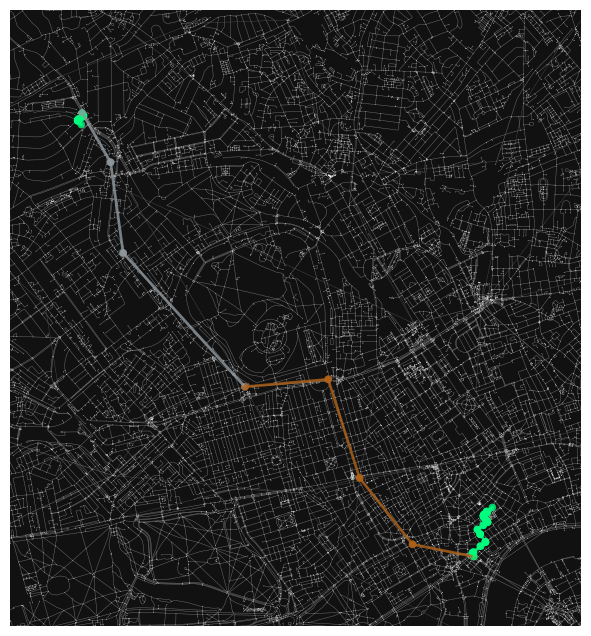

In [208]:
# find stations that are within AWD of the origin and destination
user_group = '_old'
stations_near_origin, stations_near_dest = [], []
awt_origin = awt_dest = ACCEPTABLE_WALKING_TIME
while len(stations_near_origin) < NEARBY_STATION_NUM or len(stations_near_dest) < NEARBY_STATION_NUM:
    stations_near_origin, stations_near_dest = [], []
    for station in stations_osmid:
        if nx.shortest_path_length(G_wk, origin, station, weight="time" + user_group) < awt_origin:
            stations_near_origin.append(station)
        if nx.shortest_path_length(G_wk, dest, station, weight="time" + user_group) < awt_dest:
            stations_near_dest.append(station)

    # testing
    logging.debug(f"awt1: {awt_origin/60} mins, awt2: {awt_dest/60} mins")

    if len(stations_near_origin) < NEARBY_STATION_NUM:
        awt_origin += (0.5 * 60)
    if len(stations_near_dest) < NEARBY_STATION_NUM:
        awt_dest += (0.5 * 60)

print('Nearby station to origin: ')
print(*(G.nodes[s]['station_name'] for s in stations_near_origin), sep=', ')
print('Nearby station to destination: ')
print(*(G.nodes[s]['station_name'] for s in stations_near_dest), sep=', ')

route_weight_dict = {}

for station_dest in stations_near_dest:
    for station_origin in stations_near_origin:
        # logging.debug(station, station2)
        origin_to_station = nx.shortest_path(G_wk, origin, station_origin, weight="time" + user_group)
        station_to_dest = nx.shortest_path(G_wk, station_dest, dest, weight="time" + user_group)
        tp_route = nx.shortest_path(G, station_origin, station_dest, weight="time" + user_group)
        route = origin_to_station[:-1] + tp_route + station_to_dest[1:]
        get_route_description(G, route, [], [])
        trip_time = (nx.shortest_path_length(G, station_origin, station_dest, weight='time' + user_group) \
                    + nx.shortest_path_length(G_wk, origin, station_origin, weight='time' + user_group) \
                    + nx.shortest_path_length(G_wk, station_dest, dest, weight='time' + user_group)) / 60
        logging.debug(f"Trip time: {trip_time} mins\n")

        final_weight = trip_time + (get_transfers_nums(G, route) * TRANSFERS_PENALTY)
        # routes.append(route)
        # route_final_weights.append(trip_time+get_transfers_nums(G, route))
        route_weight_dict[final_weight] = route, round(trip_time, 2)

route_chunks, route_chunk_colors = [], []

best_route, trip_time = route_weight_dict[min(route_weight_dict.keys())]
print("\n👍🏻 Final Choice:")
get_route_description(G, best_route, route_chunks, route_chunk_colors, debug=False)
print(f"Trip time: {trip_time} mins\n")

# draw the best route
north, south, east, west = get_bbox_bound(route)

fig, ax = ox.plot_graph_routes(G, route_chunks, route_linewidths=2, route_colors=route_chunk_colors, route_alpha=.8, \
                            node_color='w', node_size=.2, orig_dest_size=30, edge_linewidth=0.3, edge_color="dimgrey", edge_alpha=.7, \
                            bbox=(north, south, east, west), dpi=300) 

fig.savefig(f"output/route_{address_compact}.png", dpi=300, bbox_inches='tight')

In [209]:
# route = nx.shortest_path(G, origin, dest, weight="time")

# # plot route with diff colours for diff transport modes
# recommended_routes = []
# recommended_routes_color = []
# transfer = 0

# print(f"Start at : {origin_address}")

# last_travel_mode = 'walk'
# last_travel_stop = origin
# last_station = ''

# for i in range(len(route)-1):
#     start_node, end_node = route[i], route[i+1]
#     recommended_routes.append([start_node, end_node])
#     if 'lines_name' in G.nodes[start_node] and 'lines_name' in G.nodes[end_node]:
#         tube_line = set.intersection(G.nodes[start_node]['lines_name'], G.nodes[end_node]['lines_name']).pop()
#         recommended_routes_color.append(tube_color_dict[tube_line])
#         if last_travel_mode != 'walk' and last_travel_mode != tube_line:
#             print(f"   -> to [{last_station}]")
#         last_station = G.nodes[end_node]['station_name']
#         travel_mode = tube_line
#     else:
#         travel_mode = 'walk'
#         recommended_routes_color.append('springgreen')
    
#     if last_travel_mode != travel_mode:
#         transfer += 1
#         if last_travel_mode == 'walk':
#             print(f"{transfer}. 🚄 From [{G.nodes[start_node]['station_name']}] take {tube_line} line")
#         elif travel_mode == 'walk':
#             if last_station != '':
#                 print(f'   -> Get off at [{last_station}]')
#             print(f'{transfer}. 🚶🏻 Walk')
#         else:
#             print(f"{transfer}. 🚄 Change at [{G.nodes[start_node]['station_name']}] to {tube_line} line")

#     last_travel_mode = travel_mode

# print(f"Reaching destination: {dest_address}")
# print(f"Transfers: {transfer} times")

# north, south, east, west = get_bbox_bound(route)

# fig, ax = ox.plot_graph_routes(G, recommended_routes, route_linewidths=2, route_colors=recommended_routes_color, route_alpha=.8, \
#                             node_color='w', node_size=.2, orig_dest_size=30, edge_linewidth=0.3, edge_color="dimgrey", edge_alpha=.7, \
#                             bbox=(north, south, east, west), dpi=300) #, 

# fig.savefig(f"output/route_{address_compact}.png", dpi=300, bbox_inches='tight')

In [210]:
# total_time = nx.dijkstra_path_length(G, origin, dest, weight="time")
# print(f"Total time: {round(total_time/60, 3)} minutes")
# total_time = nx.dijkstra_path_length(G, origin, dest, weight="time_old")
# print(f"Total time: {round(total_time/60, 3)} minutes (old)")
# total_time = nx.dijkstra_path_length(G, origin, dest, weight="time_female")
# print(f"Total time: {round(total_time/60, 3)} minutes (female)")
# total_time = nx.dijkstra_path_length(G, origin, dest, weight="time_male")
# print(f"Total time: {round(total_time/60, 3)} minutes (male)")
# total_time = nx.dijkstra_path_length(G, origin, dest, weight="time_young")
# print(f"Total time: {round(total_time/60, 3)} minutes (young)")

In [211]:
# original_waypoints = [{'lat': 51.51629149999999, 'lng': -0.1755034}, {'lat': 51.507504, 'lng': -0.128672}, {'lat': 51.5076022, 'lng': -0.1289566}, {'lat': 51.5128431, 'lng': -0.1185001}, {'lat': 51.51305350000001, 'lng': -0.1175648}]
# alt1_waypoints = [{'lat': 51.516482, 'lng': -0.1779082}, {'lat': 51.5143352, 'lng': -0.1488549}, {'lat': 51.5145647, 'lng': -0.1473793}]
# alt2_waypoints = [{'lat': 51.51439999999999, 'lng': -0.149408}, {'lat': 51.517746, 'lng': -0.119719}, {'lat': 51.51305350000001, 'lng': -0.1175648}]
# original_travel_modes = [('Walking', 'Walk to Paddington'), ('Transit', 'Subway'), ('Walking', 'Walk to Trafalgar Square (Stop B)'), ('Transit', 'Bus'), ('Walking', 'Walk to 30 Aldwych, London WC2B 4BG, UK')]
# alt1_travel_modes = [('Walking', 'Walk to Paddington'), ('Transit', 'Train'), ('Walking', 'Walk to Bond Street, Bond Street Station Underground Ltd, Oxford St, London W1R 1FE, UK')]
# alt2_travel_modes = [('Walking', 'Walk to Bond Street'), ('Transit', 'Subway'), ('Walking', 'Walk to 30 Aldwych, London WC2B 4BG, UK')]

# plot routes

# paths = []
# route_colors = []
# for i in range(1, len(original_waypoints)):
#     origin = original_waypoints[i-1]['lng'], original_waypoints[i-1]['lat']
#     end = original_waypoints[i]['lng'], original_waypoints[i]['lat'] # find the nearest node to the start location
#     orig_node = ox.nearest_nodes(G, origin[0], origin[1])
#     end_node = ox.nearest_nodes(G, end[0], end[1])
#     if original_travel_modes[i][0] == "Walking":
#         route_colors.append("cornflowerblue")
#     else:
#         route_colors.append("gainsboro")
        
#     paths.append(nx.dijkstra_path(G, orig_node, end_node, weight="time"))
    
# # print(G.edges)
# fig, ax = ox.plot_graph_routes(G, paths, route_linewidths=3, route_colors=route_colors, route_alpha=.9, node_color='dimgrey', \
#                                edge_linewidth=0.3, edge_alpha=.7, edge_color="dimgrey", orig_dest_size=50, node_size=.4, \
#                                 bbox=(51.535, 51.49, -0.08457, -0.183919), dpi=300, ax=ax)
# # fig, ax = ox.plot_graph_routes(G, paths, route_linewidth=2, route_color=route_colors, route_alpha=1, node_size=.2)

# fig.savefig("output/map_original_bush_house.png", dpi=300, bbox_inches='tight')
# fig.clf()


# paths = []
# route_colors = []
# alt_waypoints = alt1_waypoints + alt2_waypoints
# alt_travel_modes = alt1_travel_modes + alt2_travel_modes
# for i in range(1, len(alt_waypoints)):
#     origin = alt_waypoints[i-1]['lng'], alt_waypoints[i-1]['lat']
#     end = alt_waypoints[i]['lng'], alt_waypoints[i]['lat']# find the nearest node to the start location
#     orig_node = ox.nearest_nodes(G, origin[0], origin[1])
#     end_node = ox.nearest_nodes(G, end[0], end[1])
#     if alt_travel_modes[i][0] == "Walking":
#         route_colors.append("springgreen")
#     else:
#         route_colors.append("gainsboro")
        
#     paths.append(nx.dijkstra_path(G, orig_node, end_node, weight="time"))

# fig, ax = ox.plot_graph_routes(G, paths, route_linewidths=3, route_colors=route_colors, route_alpha=.9, node_color='dimgrey', \
#                                edge_linewidth=0.3, edge_alpha=.7, edge_color="dimgrey", orig_dest_size=50, node_size=.4, \
#                                 bbox=(51.535, 51.49, -0.08457, -0.183919), dpi=300, ax=ax)

# # fig, ax = ox.plot_graph_routes(G, paths, route_linewidth=2, route_color=route_colors, route_alpha=1, node_size=.2, orig_dest_size=50, \
# #                               edge_linewidth=0.3, edge_color="dimgrey", edge_alpha=.7, dpi=300)

# fig.savefig("output/map_alt_bush_house.png", dpi=300, bbox_inches='tight')